In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

import src.io as sio
import src.qudi_fit_wrapper as qft
import src.helpers as shp
import src.fitting as sft

plt.style.use('seaborn')

In [2]:
DATA_FOLDER = "20220505_FR0612-F2-3B6_uhv"
DATA_FOLDERPATH, FIGURE_FOLDERPATH = sio.get_data_and_figure_paths(DATA_FOLDER)

src.io :: INFO :: qudiamond folderpath is \\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv\


# T1 measurements

In [ ]:
t1 = sio.read_pulsed_measurement_dataclass(DATA_FOLDERPATH, measurement_str="t1")

In [ ]:
t1

In [ ]:
keys_to_plot = ['20220515-2324-45', '20220516-0954-27', '20220516-1037-56', '20220516-1238-26', '20220516-1356-09', '20220517-1515-01', '20220518-1017-50']

keys_to_plot = ['20220518-1017-50']

In [ ]:
keys_to_plot = dict(list(t1.items())[-1])

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(nrows=len(keys_to_plot), sharex=True, figsize=(6, 6))

if len(keys_to_plot) == 1:
    ax = [ax]

for idx, t1_meas in enumerate(keys_to_plot.values()):
    df_data =  t1_meas.pulsed_measurement.get_data()
    x = df_data["Controlled variable(s)"] * 1e3

    # y, yerr = qft.analyse_mean_norm(t1_meas.laser_pulses.get_data(), signal_start=170e-9, signal_end=250e-9, norm_start=2000e-9, norm_end=3000e-9)
    y, yerr = qft.analyse_mean(t1_meas.laser_pulses.get_data(), signal_start=170e-9, signal_end=250e-9)
    # y, yerr = qft.analyse_mean_reference(t1_meas.laser_pulses.get_data(), signal_start=170e-9, signal_end=250e-9, norm_start=2000e-9, norm_end=3000e-9)
    # y /= np.max(y)

    ax[idx].errorbar(x, y, yerr=yerr, fmt="o")

    fit_x, fit_y, result = qft.perform_fit(x, y, "decayexponential")
    print(result.fit_report())
    ax[idx].set_title(f"{t1_meas.base_filename}")
    ax[idx].plot(fit_x, fit_y)
    
    
ax[-1].set_xlabel("Time (ms)")
fig.tight_layout()

# sio.save_figures("t1_comparison", FIGURE_FOLDERPATH)

In [ ]:
t1_meas = t1["20220518-1017-50"]

In [ ]:
t1_meas.laser_pulses.get_data()

In [ ]:
from scipy.stats import binned_statistic
from scipy.signal import savgol_filter

In [ ]:
%matplotlib widget

fig, (ax, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))

signal_start = 170e-9
signal_end = 400e-9

norm_start = 2000e-9
norm_end = 3000e-9

y = t1_meas.laser_pulses.data
x = np.arange(0, y.shape[1])  * 1e-9

bins = 500
shift = x[-1] / bins * 0.5

idx = 0
ax.plot(x, y[idx], linewidth=0.2, label="C(t = 0)")
bin_means0, bin_edges0, binnumber0 = binned_statistic(x, y[idx], statistic='mean', bins=bins)
ax.plot(bin_edges0[1:] - shift, bin_means0, label="C(t = 0) (binned)")


idx = -1
ax.plot(x, y[-1], linewidth=0.2, label="C(t = 1ms)")
bin_means1, bin_edges1, binnumber1 = binned_statistic(x, y[idx], statistic='mean', bins=bins)
ax.plot(bin_edges1[1:] - shift, bin_means1, label="C(t = 1ms) (binned)")


# ax.axvspan(signal_start, signal_end, alpha=0.2, color="tab:green")
# ax.axvspan(norm_start, norm_end, alpha=0.2, color="tab:red")
ax.set_xscale("log")
ax.legend()



y_delta = y[-1] - y[0]
xyhat = savgol_filter(y_delta, 101, 3) # window size 51, polynomial order 3
ax1.plot(x, y_delta, label="Delta C(t = 1ms) - C(t = 0)", linewidth=0.2)
ax1.plot(x, xyhat, label="Savitzky-Golay filtered")
ax1.axvspan(115e-9, 170e-9, alpha=0.1, color="tab:green")
ax1.legend()


ax2.plot(bin_edges0[1:] - shift, bin_means1 - bin_means0, label="Delta C(t = 1ms) - C(t = 0) (binned)")
ax2.legend()

# sio.save_figures("t1_delta_analysis", FIGURE_FOLDERPATH)

In [ ]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10, 5))

signal_start = 115e-9
signal_end = 170e-9

norm_start = 1500e-9
norm_end = 3000e-9


y = np.sum(t1_meas.laser_pulses.data, axis=0)
x = np.arange(0, len(y))  * 1e-9
ax.plot(x, y)

ax.axvspan(signal_start, signal_end, alpha=0.2, color="tab:green")
ax.axvspan(norm_start, norm_end, alpha=0.2, color="tab:red")

fig, ax = plt.subplots(ncols=3, sharex=True, figsize=(15, 6))

df_data =  t1_meas.pulsed_measurement.get_data()
x = df_data["Controlled variable(s)"] * 1e3


idx = 0
y, yerr = qft.analyse_mean_norm(t1_meas.laser_pulses.get_data(), signal_start=signal_start, signal_end=signal_end, norm_start=norm_start, norm_end=norm_end)
ax[idx].errorbar(x, y, yerr=yerr, fmt="o")
fit_x, fit_y, result = qft.perform_fit(x, y, "decayexponential")
print("mean_norm", result.best_values)
ax[idx].set_title(f"mean_norm")
ax[idx].plot(fit_x, fit_y)
    
idx = 1
y, yerr = qft.analyse_mean(t1_meas.laser_pulses.get_data(), signal_start=signal_start, signal_end=signal_end)
ax[idx].errorbar(x, y, yerr=yerr, fmt="o")
fit_x, fit_y, result = qft.perform_fit(x, y, "decayexponential")
print("mean", result.best_values)
ax[idx].set_title(f"mean")
ax[idx].plot(fit_x, fit_y)

idx = 2
y, yerr = qft.analyse_mean_reference(t1_meas.laser_pulses.get_data(), signal_start=signal_start, signal_end=signal_end, norm_start=norm_start, norm_end=norm_end)
ax[idx].errorbar(x, y, yerr=yerr, fmt="o")
fit_x, fit_y, result = qft.perform_fit(x, y, "decayexponential")
print("mean_ref", result.best_values)
ax[idx].set_title(f"mean_ref")
ax[idx].plot(fit_x, fit_y)


ax[-1].set_xlabel("Time (ms)")
fig.tight_layout()

# sio.save_figures("t1_comparison", FIGURE_FOLDERPATH)

In [ ]:
autocorr_paths, autocorr_files = sio.get_measurement_file_list(DATA_FOLDERPATH, "Autocorrelation")

In [ ]:
main_pressures = np.array([1.78, 2.32, 2.89, 3.51, 4.2, 5.04, 5.98, 7.11, 8.27, 9.6]) * 1e-6

In [ ]:
fig, ax = plt.subplots()

idx = 0
for auto_path, auto_file in zip(autocorr_paths, autocorr_files):
    if "idx" in auto_path:
        df = sio.read_into_df(auto_path)
        
        x = df["Time (ps)"] / 1e3
        y = df["g2(t) norm"]
        ax.plot(x, y, label=shp.format_exponent_as_str(main_pressures[idx]))
        
        idx += 1 
        
ax.legend()

ax.set_ylabel("g(2) norm")
ax.set_xlabel("Time (ns)")

fig.tight_layout()
sio.save_figures("autocorr_comparison_pressure", FIGURE_FOLDERPATH)

In [ ]:
confocal_paths, confocal_files = sio.get_measurement_file_list(DATA_FOLDERPATH, "Confocal")

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 8), sharex=True, sharey=True)

i, j = 1, 4
idx = 9
for path, name in zip(confocal_paths, confocal_files):
    if "idx" in path and "image" in path:
        params = sio.read_qudi_parameters(path)
        data = np.genfromtxt(path, dtype=None, delimiter='\t')
        extent = np.array([params['X image min (m)'], params['X image max (m)'], params['Y image min'], params['Y image max']]) * 1e3
        img = ax[i, j].imshow(data/1e3, cmap="viridis", origin="lower", extent=extent, vmin=0, vmax=350)
        ax[i, j].grid(False)
        ax[i, j].set_title(shp.format_exponent_as_str(main_pressures[idx]))
        
        j -= 1
        if j < 0:
            i -= 1
            j = 4
        idx -= 1
            
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("Fluorescence (kc/s)")

sio.save_figures("confocal_comparison_pressure", FIGURE_FOLDERPATH)

# Autocorrelation

In [3]:
autocorr_paths, autocorr_files = sio.get_measurement_file_list(DATA_FOLDERPATH, "Autocorrelation")

\\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv\2022\05\20220518\PulsedMeasurement: : 46it [00:46,  1.00s/it]


In [ ]:
autocorr_files

1.218152476050924
1.381610569603428
1.134185249191802 0.5
1.918560415409187
1.3886405168135643 0.6
2.843619491933922
1.482163120376608 0.6666666666666666


Text(0, 0.5, 'g(2) norm')

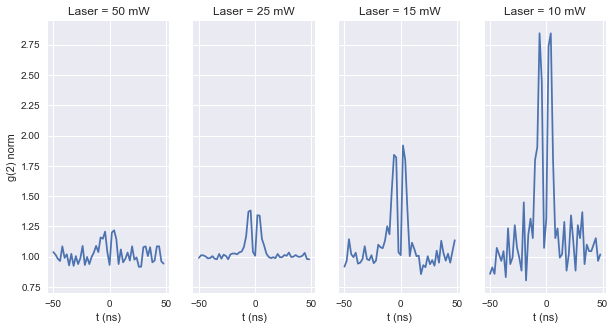

In [8]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10, 5))

idx = 0
for autocorr_file, autocorr_path in zip(autocorr_files, autocorr_paths):
    if "_right_spot_" in autocorr_path and "mW" in autocorr_path:
        df = sio.read_into_df(autocorr_path)
        df["shot_noise"] = df["g2(t)"].pow(0.5)
        x = df["Time (ps)"] / 1e3
        y = df["g2(t) norm"]
        
        ax[idx].plot(x, y)
        ax[idx].set_title("Laser = " + autocorr_file[28:30] + " mW")
        ax[idx].set_xlabel("t (ns)")
        idx += 1
        print(np.max(y))
        if idx > 1:
            print(np.max(y) / max_g2, int(autocorr_file[28:30]) / laser_power)
        max_g2 = np.max(y)
        laser_power = int(autocorr_file[28:30])

ax[0].set_ylabel("g(2) norm")

# sio.save_figures("autocorr_variation_with_laserpower", FIGURE_FOLDERPATH)

In [15]:
from scipy.optimize import curve_fit

src.fit_logic :: INFO :: Methods were included to FitLogic, but only if naming is right: check the doxygen documentation if you added a new method and it does not show.
src.fit_logic :: WARNING :: The estimation for linear fit did not work.


Text(0.5, 0, 'Laser power')

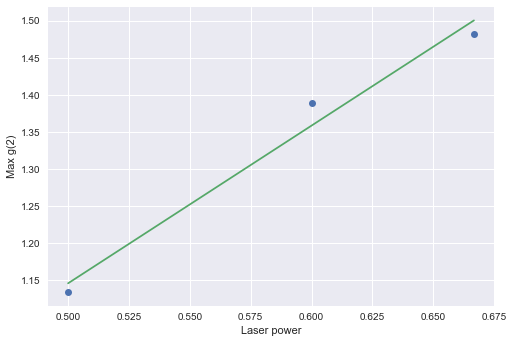

In [32]:
heights = np.array([1.218152476050924, 1.381610569603428, 1.918560415409187, 2.843619491933922])
laser_powers = np.array([50, 25, 15, 10])

height_ratios = [heights[idx] / heights[idx - 1] for idx in range(1, 4)]
power_ratios = [laser_powers[idx] / laser_powers[idx - 1] for idx in range(1, 4)]

fig, ax = plt.subplots()

ax.plot(power_ratios, height_ratios, "o")

fit_x, fit_y, result = qft.perform_fit(power_ratios, height_ratios, "linear")
ax.plot(fit_x, fit_y, "-")

ax.set_ylabel("Max g(2)")
ax.set_xlabel("Laser power")

In [33]:
height_ratios

[1.134185249191802, 1.3886405168135643, 1.482163120376608]

In [34]:
power_ratios

[0.5, 0.6, 0.6666666666666666]